<a href="https://colab.research.google.com/github/Asad1287/50-Mini-Generative-AI-Lessons/blob/main/Day4_AutoEncoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from typing import List, Tuple, Optional, Union
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

class Encoder(layers.Layer):
    """Custom encoder layer that compresses the input data into a latent space representation."""

    def __init__(
        self,
        latent_dim: int,
        intermediate_dims: List[int],
        name: str = "encoder",
        **kwargs
    ) -> None:
        """
        Initialize the encoder layer.

        Args:
            latent_dim (int): Dimension of the latent space
            intermediate_dims (List[int]): List of dimensions for intermediate layers
            name (str): Name of the layer
            **kwargs: Additional arguments to pass to the parent Layer class
        """
        super(Encoder, self).__init__(name=name, **kwargs)

        self.latent_dim = latent_dim
        self.intermediate_dims = intermediate_dims

        # Create dense layers for dimensionality reduction
        self.dense_layers = [
            layers.Dense(
                dim,
                activation='relu',
                name=f'encoder_dense_{i}'
            ) for i, dim in enumerate(intermediate_dims)
        ]

        # Final dense layer for latent space projection
        self.latent_layer = layers.Dense(
            latent_dim,
            name='latent_projection'
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the encoder.

        Args:
            inputs (tf.Tensor): Input tensor to encode

        Returns:
            tf.Tensor: Encoded representation in latent space
        """
        x = inputs
        # Pass through intermediate layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)

        # Project to latent space
        latent = self.latent_layer(x)
        return latent

    def get_config(self) -> dict:
        """
        Get layer configuration for serialization.

        Returns:
            dict: Layer configuration
        """
        config = super(Encoder, self).get_config()
        config.update({
            'latent_dim': self.latent_dim,
            'intermediate_dims': self.intermediate_dims
        })
        return config


class Decoder(layers.Layer):
    """Custom decoder layer that reconstructs the input from its latent representation."""

    def __init__(
        self,
        original_dim: int,
        intermediate_dims: List[int],
        name: str = "decoder",
        **kwargs
    ) -> None:
        """
        Initialize the decoder layer.

        Args:
            original_dim (int): Dimension of the original input space
            intermediate_dims (List[int]): List of dimensions for intermediate layers
            name (str): Name of the layer
            **kwargs: Additional arguments to pass to the parent Layer class
        """
        super(Decoder, self).__init__(name=name, **kwargs)

        self.original_dim = original_dim
        self.intermediate_dims = intermediate_dims

        # Create dense layers for reconstruction
        self.dense_layers = [
            layers.Dense(
                dim,
                activation='relu',
                name=f'decoder_dense_{i}'
            ) for i, dim in enumerate(intermediate_dims)
        ]

        # Final dense layer for output reconstruction
        self.output_layer = layers.Dense(
            original_dim,
            activation='sigmoid',
            name='output_reconstruction'
        )

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the decoder.

        Args:
            inputs (tf.Tensor): Latent space representation to decode

        Returns:
            tf.Tensor: Reconstructed output in original space
        """
        x = inputs
        # Pass through intermediate layers
        for dense_layer in self.dense_layers:
            x = dense_layer(x)

        # Reconstruct original dimensions
        decoded = self.output_layer(x)
        return decoded

    def get_config(self) -> dict:
        """
        Get layer configuration for serialization.

        Returns:
            dict: Layer configuration
        """
        config = super(Decoder, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'intermediate_dims': self.intermediate_dims
        })
        return config


class Autoencoder(Model):
    """Custom autoencoder model that combines encoder and decoder for dimensionality reduction."""

    def __init__(
        self,
        original_dim: int,
        latent_dim: int,
        encoder_dims: List[int],
        decoder_dims: List[int],
        name: str = "autoencoder",
        **kwargs
    ) -> None:
        """
        Initialize the autoencoder model.

        Args:
            original_dim (int): Dimension of the original input space
            latent_dim (int): Dimension of the latent space
            encoder_dims (List[int]): List of dimensions for encoder intermediate layers
            decoder_dims (List[int]): List of dimensions for decoder intermediate layers
            name (str): Name of the model
            **kwargs: Additional arguments to pass to the parent Model class
        """
        super(Autoencoder, self).__init__(name=name, **kwargs)

        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.encoder_dims = encoder_dims
        self.decoder_dims = decoder_dims

        # Initialize encoder and decoder
        self.encoder = Encoder(latent_dim, encoder_dims)
        self.decoder = Decoder(original_dim, decoder_dims)

    def call(self, inputs: tf.Tensor) -> tf.Tensor:
        """
        Forward pass of the autoencoder.

        Args:
            inputs (tf.Tensor): Input tensor to encode and decode

        Returns:
            tf.Tensor: Reconstructed output
        """
        # Encode input to latent space
        encoded = self.encoder(inputs)
        # Decode latent representation
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, inputs: Union[np.ndarray, tf.Tensor]) -> tf.Tensor:
        """
        Encode input data to latent space.

        Args:
            inputs (Union[np.ndarray, tf.Tensor]): Input data to encode

        Returns:
            tf.Tensor: Encoded representation
        """
        return self.encoder(inputs)

    def decode(self, latent: Union[np.ndarray, tf.Tensor]) -> tf.Tensor:
        """
        Decode latent space representation.

        Args:
            latent (Union[np.ndarray, tf.Tensor]): Latent space representation to decode

        Returns:
            tf.Tensor: Reconstructed output
        """
        return self.decoder(latent)

    def get_config(self) -> dict:
        """
        Get model configuration for serialization.

        Returns:
            dict: Model configuration
        """
        config = super(Autoencoder, self).get_config()
        config.update({
            'original_dim': self.original_dim,
            'latent_dim': self.latent_dim,
            'encoder_dims': self.encoder_dims,
            'decoder_dims': self.decoder_dims
        })
        return config


# Example usage
def create_autoencoder(
    input_dim: int,
    latent_dim: int,
    encoder_layers: List[int],
    decoder_layers: List[int]
) -> Autoencoder:
    """
    Create and compile an autoencoder model.

    Args:
        input_dim (int): Dimension of input data
        latent_dim (int): Dimension of latent space
        encoder_layers (List[int]): Dimensions of encoder intermediate layers
        decoder_layers (List[int]): Dimensions of decoder intermediate layers

    Returns:
        Autoencoder: Compiled autoencoder model
    """
    # Initialize autoencoder
    autoencoder = Autoencoder(
        original_dim=input_dim,
        latent_dim=latent_dim,
        encoder_dims=encoder_layers,
        decoder_dims=decoder_layers
    )

    # Compile model
    autoencoder.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return autoencoder

# Example model creation
if __name__ == "__main__":
    # Define model parameters
    INPUT_DIM: int = 784  # e.g., for MNIST
    LATENT_DIM: int = 32
    ENCODER_LAYERS: List[int] = [256, 128, 64]
    DECODER_LAYERS: List[int] = [64, 128, 256]

    # Create model
    model = create_autoencoder(
        input_dim=INPUT_DIM,
        latent_dim=LATENT_DIM,
        encoder_layers=ENCODER_LAYERS,
        decoder_layers=DECODER_LAYERS
    )

    # Print model summary
    model.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0833 - mae: 0.2500 - val_loss: 0.0832 - val_mae: 0.2498
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0832 - mae: 0.2498 - val_loss: 0.0832 - val_mae: 0.2497
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0831 - mae: 0.2497 - val_loss: 0.0832 - val_mae: 0.2497
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0830 - mae: 0.2494 - val_loss: 0.0831 - val_mae: 0.2497
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0833 - mae: 0.2498 - val_loss: 0.0831 - val_mae: 0.2496
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0830 - mae: 0.2494 - val_loss: 0.0831 - val_mae: 0.2495
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0829 - mae: 0.2492 - val_loss: 0.0829 - val_mae: 0.2492
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0829 - mae: 0.2490 - val_loss: 0.0827 - val_mae: 0.2489
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.082

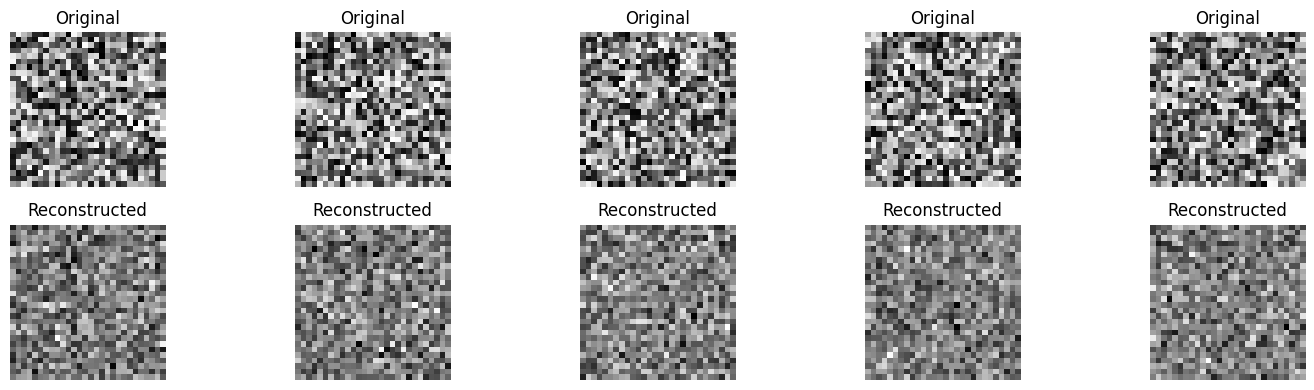

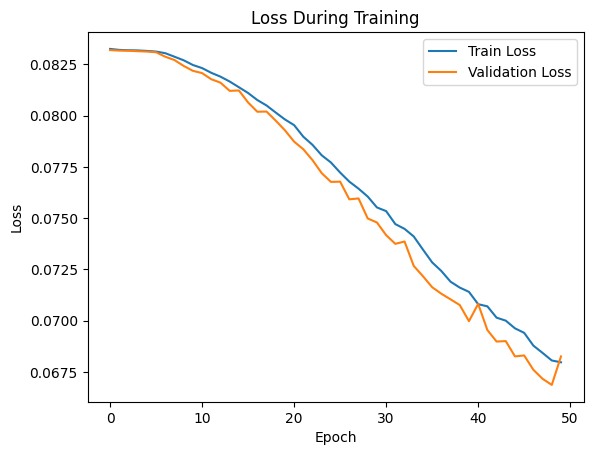

In [2]:
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model

# Encoder, Decoder, Autoencoder classes are assumed to be defined as provided

def create_synthetic_data(samples: int = 1000, features: int = 784) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create synthetic data for autoencoder training.
    """
    np.random.seed(42)
    x = np.random.rand(samples, features).astype(np.float32)
    return x, x  # For autoencoder, input and output are the same

def plot_reconstructed_data(original: np.ndarray, reconstructed: np.ndarray, n_samples: int = 5) -> None:
    """
    Plot the original and reconstructed data side-by-side.
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))
    for i in range(n_samples):
        # Original
        axes[0, i].imshow(original[i].reshape(28, 28), cmap="gray")
        axes[0, i].set_title("Original")
        axes[0, i].axis("off")

        # Reconstructed
        axes[1, i].imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

def main():
    # Define dataset dimensions (MNIST-like dataset)
    INPUT_DIM = 784  # 28x28 images
    LATENT_DIM = 32
    ENCODER_LAYERS = [256, 128, 64]
    DECODER_LAYERS = [64, 128, 256]

    # Generate synthetic data
    x_train, x_test = create_synthetic_data(samples=1000, features=INPUT_DIM)

    # Create autoencoder
    autoencoder = create_autoencoder(
        input_dim=INPUT_DIM,
        latent_dim=LATENT_DIM,
        encoder_layers=ENCODER_LAYERS,
        decoder_layers=DECODER_LAYERS
    )

    # Train autoencoder
    history = autoencoder.fit(
        x_train,
        x_train,
        validation_data=(x_test, x_test),
        epochs=50,
        batch_size=32,
        verbose=1
    )

    # Test reconstruction
    reconstructed = autoencoder.predict(x_test[:10])

    # Plot the original vs reconstructed data
    plot_reconstructed_data(x_test[:10], reconstructed)

    # Visualize learning (Loss curve)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss During Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

if __name__ == "__main__":
    main()
